In [7]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ShiftingWindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, H, W, C = x.shape
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))
        _, Hp, Wp, _ = x.shape

        x = x.view(B, Hp // self.window_size, self.window_size, Wp // self.window_size, self.window_size, C)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, self.window_size * self.window_size, C)

        qkv = self.qkv(windows).reshape(-1, self.window_size * self.window_size, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(-1, self.window_size * self.window_size, C)
        x = self.proj(x)

        x = x.view(B, Hp // self.window_size, Wp // self.window_size, self.window_size, self.window_size, C)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, Hp, Wp, C)
        if pad_h > 0 or pad_w > 0:
            x = x[:, :H, :W, :].contiguous()
        return x

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias, physics_kernel_size, window_size, num_heads):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

        self.physics_conv_x = nn.Conv2d(in_channels=self.input_dim,
                                        out_channels=self.hidden_dim,
                                        kernel_size=physics_kernel_size,
                                        padding=physics_kernel_size[0] // 2,
                                        bias=False)

        self.physics_conv_y = nn.Conv2d(in_channels=self.input_dim,
                                        out_channels=self.hidden_dim,
                                        kernel_size=physics_kernel_size,
                                        padding=physics_kernel_size[1] // 2,
                                        bias=False)

        self.attention = ShiftingWindowAttention(hidden_dim, window_size, num_heads)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        if input_tensor.dim() == 5:
            input_tensor = input_tensor.squeeze(1)

        if input_tensor.size(1) != self.input_dim:
            raise ValueError(f"Expected input_tensor to have {self.input_dim} channels, but got {input_tensor.size(1)} channels instead")

        if h_cur.size(1) != self.hidden_dim:
            raise ValueError(f"Expected h_cur to have {self.hidden_dim} channels, but got {h_cur.size(1)} channels instead")

        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)

        physics_conv_x = self.physics_conv_x(input_tensor)
        physics_conv_y = self.physics_conv_y(input_tensor)

        i = torch.sigmoid(cc_i + physics_conv_x)
        f = torch.sigmoid(cc_f + physics_conv_x)
        o = torch.sigmoid(cc_o + physics_conv_y)
        g = torch.tanh(cc_g + physics_conv_y)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        # Apply shifting window attention
        h_next = h_next.permute(0, 2, 3, 1)  # Change to (B, H, W, C)
        h_next = self.attention(h_next)
        h_next = h_next.permute(0, 3, 1, 2)  # Change back to (B, C, H, W)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, physics_kernel_size, output_dim,
                 batch_first=False, bias=True, return_all_layers=False, window_size=8, num_heads=4):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias,
                                          physics_kernel_size=physics_kernel_size,
                                          window_size=window_size,
                                          num_heads=num_heads))

        self.cell_list = nn.ModuleList(cell_list)
        self.output_conv = nn.Conv2d(in_channels=hidden_dim[-1],
                                     out_channels=output_dim,
                                     kernel_size=1,
                                     padding=0)
        # Initialize velocities as trainable parameters
        self.velocity_x = nn.Parameter(torch.tensor(0.1))
        self.velocity_y = nn.Parameter(torch.tensor(0.1))

   
    def forward(self, input_tensor, hidden_state=None):
        if input_tensor.dim() == 4:
            # (b, h, w, c) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(0, 3, 1, 2).unsqueeze(1)
        elif input_tensor.dim() == 5:
            if not self.batch_first:
                # (t, b, c, h, w) -> (b, t, c, h, w)
                input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, t, _, h, w = input_tensor.size()

        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        # Remove the sequence length dimension before applying the output convolution
        output = self.output_conv(layer_output_list[0].squeeze(1))
        # Permute the output to have shape (b, h, w, c)
        output = output.permute(0, 2, 3, 1)
        return output, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param
    
    def advection_loss(self, input_tensor, output_tensor):
        grad = torch.autograd.grad(outputs=output_tensor, inputs=input_tensor,
                                   grad_outputs=torch.ones_like(output_tensor), create_graph=True)[0]
        dudx = grad[:, :, 0]
        dudy = grad[:, :, 1]
        dudt = grad[:, :, 2]

        physics = dudt + self.velocity_x * dudx + self.velocity_y * dudy
        loss = torch.mean((physics) ** 2)

        return loss

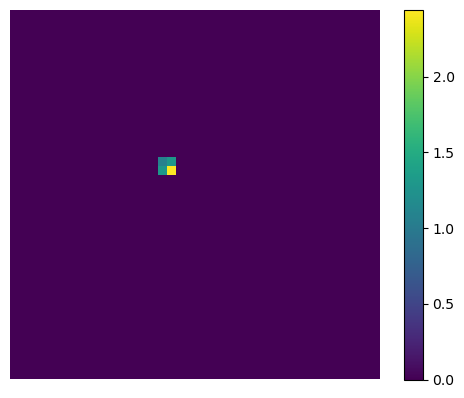

/home/sushen/anaconda3/envs/pinn/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


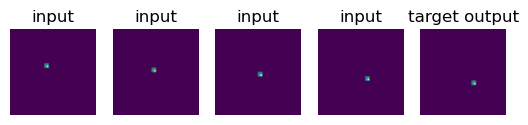

x_train shape: (588, 40, 40, 4)
x_validate shape: (196, 40, 40, 4)
x_test shape: (196, 40, 40, 4)
y_train shape: (588, 40, 40, 1)
y_validate shape: (196, 40, 40, 1)
y_test shape: (196, 40, 40, 1)


In [15]:
# load radar data
movies = np.load('/home/sushen/PhysNet-RadarNowcast/src/datasets/rect_movie.npy')
movies.shape # (980, 40, 40, 20) -- here each movie is of length 20

# in our model we will use the first four images as inputs and predict the
# fifth image
x = movies[:, :, :,  :4]
y = movies[:, :, :, 4:5]


# function: animation of a sequence of radar data (shape = nx,ny,ntime)
def animate(x):
  fig, ax = plt.subplots()
  vmax = np.max(x)
  im = ax.imshow(x[:,:,0], vmin=0, vmax=vmax)
  fig.colorbar(im)
  plt.axis('off')
  def anim_(i):
      im.set_data(x[:,:,i])
      ax.set_title(str(i+1) + '/' + str(x.shape[2]))
  anim = animation.FuncAnimation(
      fig, anim_, interval=300, frames=x.shape[2], repeat_delay=1000)
  plt.show()

# i_plt = 340
# i_plt = 123
i_plt = np.int32(np.random.sample() * movies.shape[0])
animate(x[i_plt,:,:,:])
plt.show()

# train validate test split
tvt = np.tile(['train','train','train','validate','test'], y.shape[0])[:y.shape[0]]
x_train = x[np.where(tvt == 'train')]
y_train = y[np.where(tvt == 'train')]
x_validate = x[np.where(tvt == 'validate')]
y_validate = y[np.where(tvt == 'validate')]
x_test = x[np.where(tvt == 'test')]
y_test = y[np.where(tvt == 'test')]

n_test = x_test.shape[0]
i_plt = np.int32(np.random.sample() * n_test)
true = np.append(x_test[i_plt,:,:,:], y_test[i_plt,:,:,:], axis=2)
# plot an input/output pair
i_plt = 20
i_plt = np.int32(np.random.sample() * x_train.shape[0])
for jj in range(4):
  plt.subplot(1,5,jj+1)
  plt.imshow(x_train[i_plt,:,:,jj])
  plt.axis('off')
  plt.title('input')
plt.subplot(1,5,5)
plt.imshow(y_train[i_plt,:,:,0])
plt.title('target output')
plt.axis('off')
plt.show()


# Assuming x_train, x_validate, x_test, y_train, y_validate, and y_test are defined
print("x_train shape:", np.shape(x_train))
print("x_validate shape:", np.shape(x_validate))
print("x_test shape:", np.shape(x_test))
print("y_train shape:", np.shape(y_train))
print("y_validate shape:", np.shape(y_validate))
print("y_test shape:", np.shape(y_test))

device = torch.device("cuda")
torch.cuda.empty_cache()
train_dataset = TensorDataset(torch.from_numpy(x_train).float().requires_grad_(), torch.from_numpy(y_train).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.from_numpy(x_validate).float().requires_grad_(), torch.from_numpy(y_validate).float())
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(torch.from_numpy(x_test).float().requires_grad_(), torch.from_numpy(y_test).float())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
torch.cuda.memory_summary(device=None, abbreviated=False)
def update_grid(rin_physics):
    # Get the shape of the input tensor
    shape = rin_physics.shape
    # Create an empty tensor with the same shape
    updated_grid = np.zeros(shape)

    # Iterate through each element in the batch
    for i in range(shape[0]):
        # Extract the individual grid
        grid = rin_physics[i]

        # Find the max and min x, y values
        max_x, max_y = np.unravel_index(np.argmax(grid[:, :, 0]), grid[:, :, 0].shape)
        min_x, min_y = np.unravel_index(np.argmin(grid[:, :, 0]), grid[:, :, 0].shape)

        # Set the pattern
        updated_grid[i, max_x, max_y, :] = 1
        updated_grid[i, min_x, min_y, :] = 0

    return updated_grid

In [16]:



model = ConvLSTM(input_dim=4, hidden_dim=[128, 64], kernel_size=(3,3), num_layers=2, 
                 physics_kernel_size=(3,3), output_dim=1, batch_first=True, bias=True, 
                 return_all_layers=False, window_size=1, num_heads=8)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 50
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    
    model.train()
    train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output, _ = model(batch_x)
        output = output.squeeze(1)
        # Enable gradients for the output tensor
        output.requires_grad_(True)
        
        # Compute data loss
        
        data_loss = criterion(output, batch_y)
        
        # Compute physics loss

        # Create an empty tensor with the same shape as batch_x
        rin_physics = torch.zeros_like(batch_x, device=device, requires_grad=True)
        rin_physics = update_grid(rin_physics.cpu().detach().numpy())
        # print(rin_physics.shape, batch_x.shape)
        # print("Shape after update_grid:", rin_physics.shape)
       # rin_physics = rin_physics.view(32, 40, 40, 4)  # Use view instead of reshape
        rin_physics = torch.tensor(rin_physics,dtype=torch.float32,device=device, requires_grad=True)  # Move back to GPU if needed
        
        output, _ = model(rin_physics)
        physics_loss = model.advection_loss(rin_physics, output)
        
        # Combine losses
        loss = data_loss   +  physics_loss 
        
        # loss = torch.max(0.5 * torch.abs(data_loss - physics_loss))
        # Backward pass
        loss.backward(retain_graph=True)
        
        # Update weights and velocities
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Forward pass
            output, _ = model(batch_x)
            output = output.squeeze(1)
            
            # Compute data loss
            data_loss = criterion(output, batch_y)
            
            
            
            # Combine losses
            loss = data_loss 
            
            val_loss += loss.item() * batch_x.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Testing loop
model.eval()
test_loss = 0.0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
       
        # Forward pass
        output, _ = model(batch_x)
        output = output.squeeze(1)
        
        # Compute data loss
        data_loss = criterion(output, batch_y)
        
        # Combine losses
        loss = data_loss 
        
        test_loss += loss.item() * batch_x.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/50]
Train Loss: 0.0034, Val Loss: 0.0028
Epoch [2/50]
Train Loss: 0.0027, Val Loss: 0.0028
Epoch [3/50]
Train Loss: 0.0027, Val Loss: 0.0028
Epoch [4/50]
Train Loss: 0.0026, Val Loss: 0.0024
Epoch [5/50]
Train Loss: 0.0023, Val Loss: 0.0023
Epoch [6/50]
Train Loss: 0.0022, Val Loss: 0.0022
Epoch [7/50]
Train Loss: 0.0022, Val Loss: 0.0022
Epoch [8/50]
Train Loss: 0.0022, Val Loss: 0.0022
Epoch [9/50]
Train Loss: 0.0022, Val Loss: 0.0022
Epoch [10/50]
Train Loss: 0.0021, Val Loss: 0.0022
Epoch [11/50]
Train Loss: 0.0021, Val Loss: 0.0022
Epoch [12/50]
Train Loss: 0.0021, Val Loss: 0.0022
Epoch [13/50]
Train Loss: 0.0021, Val Loss: 0.0022
Epoch [14/50]
Train Loss: 0.0021, Val Loss: 0.0022
Epoch [15/50]
Train Loss: 0.0021, Val Loss: 0.0022
Epoch [16/50]
Train Loss: 0.0021, Val Loss: 0.0022
Epoch [17/50]
Train Loss: 0.0021, Val Loss: 0.0022
Epoch [18/50]
Train Loss: 0.0021, Val Loss: 0.0022
Epoch [19/50]
Train Loss: 0.0021, Val Loss: 0.0022
Epoch [20/50]
Train Loss: 0.0021, Val Lo

In [22]:

torch.save(model.state_dict(), '/home/sushen/PhysNet-RadarNowcast/src/models/convLSTM_attention_physics_dynamic_grid.pth'  )


In [28]:
# Initialize the model
model = ConvLSTM(input_dim=4, hidden_dim=[128, 64], kernel_size=(3,3), num_layers=2,
                 physics_kernel_size=(3,3), output_dim=1, batch_first=True, bias=True,
                 return_all_layers=False, window_size=1, num_heads=8)

# Specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model parameters from a .pth file
model.load_state_dict(torch.load("/home/sushen/PhysNet-RadarNowcast/src/models/convLSTM_attention_physics_dynamic_grid.pth"
                                 "", map_location=device))

model.eval()

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(132, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (physics_conv_x): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (physics_conv_y): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (attention): ShiftingWindowAttention(
        (qkv): Linear(in_features=128, out_features=384, bias=False)
        (proj): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (physics_conv_x): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (physics_conv_y): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (attention): ShiftingWindowAttention(
        (qkv): Linear(in_features=64, out_features=192, bias=False)
        (proj): Linear(in_features=

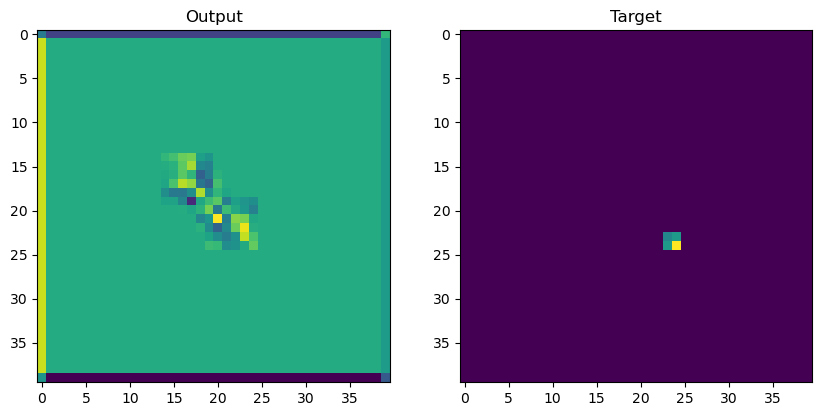

In [29]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch

def animate_comparison(model, data_loader, output_folder):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Extract a single batch for visualization
    inputs, targets = next(iter(data_loader))
    
    # Move inputs to the same device as the model
    inputs = inputs.to(next(model.parameters()).device)
    
    # Get model predictions
    with torch.no_grad():
        
        outputs,states = model(inputs)
    
    # Assuming outputs and targets are on GPU, move them to CPU and convert to numpy
    outputs = outputs.cpu().numpy()
    targets = targets.cpu().numpy()
    
    # Prepare figure for animation
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    def update(i):
        # Clear previous content
        ax[0].cla()
        ax[1].cla()
        
        # Update content for frame i
        ax[0].imshow(outputs[i].squeeze(), cmap='viridis')
        ax[0].set_title('Output')
        ax[1].imshow(targets[i].squeeze(), cmap='viridis')
        ax[1].set_title('Target')
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(outputs), interval=2000)
    
    # Save animation
    anim.save(f'{output_folder}/convLSTM_attention_physics_comparison_animation.gif', writer='imagemagick')

# Example usage
animate_comparison(model, test_loader, '/home/sushen/PhysNet-RadarNowcast/images/convLSTM_attention_ipinn')